In [14]:
import time
import os
import math
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
from PIL import Image
from wilds import get_dataset
from wilds.common.data_loaders import get_train_loader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

#######################
# Hyperparameters & Config
#######################

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 20
KD_TEMPERATURE = 4.0
KD_ALPHA = 0.5
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

Using device: cuda


In [15]:
dataset = get_dataset(dataset="waterbirds", download=True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_data = dataset.get_subset("train", transform=transform)
val_data = dataset.get_subset("val", transform=transform)
test_data = dataset.get_subset("test", transform=transform)

train_loader = get_train_loader("standard", train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

metadata_array = test_data.metadata_array
bird_type_idx = dataset.metadata_fields.index('y')
background_idx = dataset.metadata_fields.index('background')

bird_type = metadata_array[:, bird_type_idx]
background = metadata_array[:, background_idx]

id_mask = ((bird_type == 0) & (background == 0)) | ((bird_type == 1) & (background == 1))
id_indices = torch.where(id_mask)[0]
id_data = Subset(test_data, id_indices)
id_loader = DataLoader(id_data, batch_size=BATCH_SIZE, shuffle=False)

ood_mask = ((bird_type == 0) & (background == 1)) | ((bird_type == 1) & (background == 0))
ood_indices = torch.where(ood_mask)[0]
ood_data = Subset(test_data, ood_indices)
ood_loader = DataLoader(ood_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_data)}")
print(f"Val samples:   {len(val_data)}")
print(f"Test samples:  {len(test_data)}")
print(f"ID samples:    {len(id_data)}")
print(f"OOD samples:   {len(ood_data)}")

Train samples: 4795
Val samples:   1199
Test samples:  5794
ID samples:    2897
OOD samples:   2897


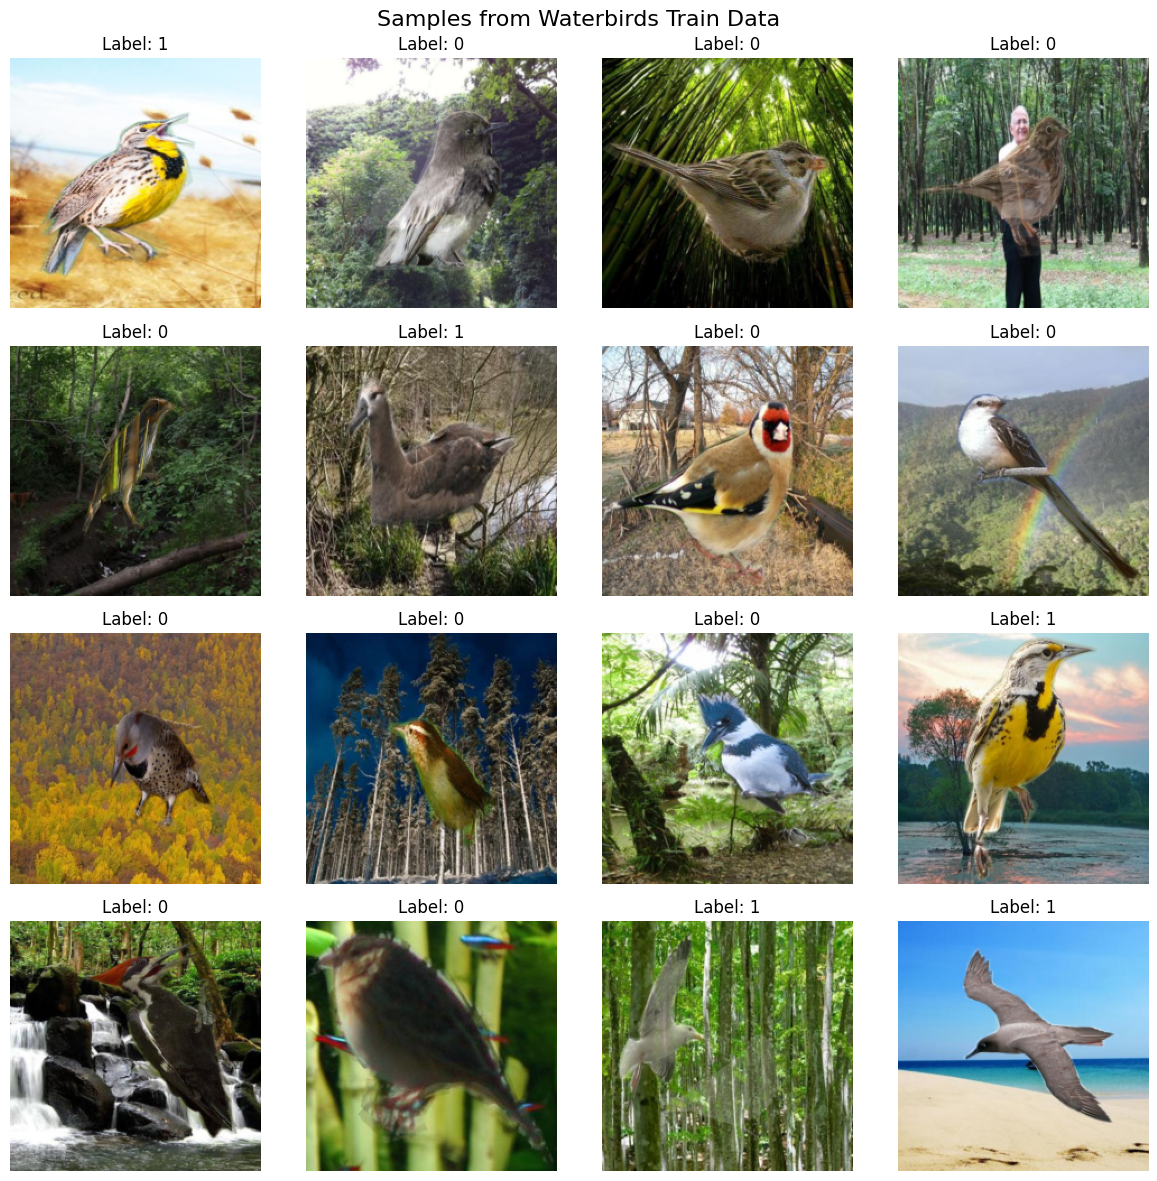

In [16]:
def visualize_samples(data_loader, num_samples=16, dataset_name="Dataset"):
    """
    Visualize a few samples from a given DataLoader.

    Parameters:
    - data_loader: DataLoader object to fetch samples from
    - num_samples: Number of samples to visualize (default: 16)
    - dataset_name: Title for the visualization (default: 'Dataset')
    """
    images, labels = [], []

    for idx, (img, label, *metadata) in enumerate(data_loader):
        images.extend(img)
        labels.extend(label.tolist())
        if len(images) >= num_samples:
            break

    images = images[:num_samples]
    labels = labels[:num_samples]

    grid_size = int(math.sqrt(num_samples))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axs = axs.flatten()

    for i, (img, label) in enumerate(zip(images, labels)):
        ax = axs[i]
        img = img.permute(1, 2, 0).numpy() 
        ax.imshow(img)
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    for j in range(len(images), len(axs)):
        axs[j].axis('off')

    plt.suptitle(f"Samples from {dataset_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

visualize_samples(train_loader, num_samples=16, dataset_name="Waterbirds Train Data")

In [17]:

teacher_model = torch.hub.load('pytorch/vision:v0.13.0', 'resnet50', pretrained=False)
teacher_model.fc = nn.Linear(2048, 2)
teacher_model = teacher_model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=LR)

def train_teacher(model, train_loader, val_loader, epochs=5):
    """
    Fine-tunes the teacher model on Waterbirds for a given number of epochs.
    """
    print("===== Fine-tuning Teacher (ResNet50) =====")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for images, labels, _ in tqdm(train_loader, desc=f"Teacher Train Epoch {epoch+1}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * len(labels)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += len(labels)

        train_loss = running_loss / total
        train_acc = 100.0 * correct / total

        val_loss, val_acc = evaluate_model(model, val_loader)

        print(f"[Epoch {epoch+1}/{epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    print("Teacher training complete.\n")

def evaluate_model(model, data_loader):
    """
    Returns (avg_loss, accuracy) for the model on given data_loader.
    """
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * len(labels)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += len(labels)
    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

train_teacher(teacher_model, train_loader, val_loader, epochs=20)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


===== Fine-tuning Teacher (ResNet50) =====


Teacher Train Epoch 1: 100%|██████████| 150/150 [01:06<00:00,  2.24it/s]


[Epoch 1/20] Train Loss: 0.4186, Train Acc: 84.05% | Val Loss: 0.8202, Val Acc: 66.22%


Teacher Train Epoch 2: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]


[Epoch 2/20] Train Loss: 0.3100, Train Acc: 87.09% | Val Loss: 0.9046, Val Acc: 75.73%


Teacher Train Epoch 3: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]


[Epoch 3/20] Train Loss: 0.3030, Train Acc: 88.74% | Val Loss: 0.7356, Val Acc: 70.73%


Teacher Train Epoch 4: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]


[Epoch 4/20] Train Loss: 0.2943, Train Acc: 88.28% | Val Loss: 1.1928, Val Acc: 46.96%


Teacher Train Epoch 5: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]


[Epoch 5/20] Train Loss: 0.2861, Train Acc: 88.80% | Val Loss: 0.8907, Val Acc: 59.38%


Teacher Train Epoch 6: 100%|██████████| 150/150 [01:05<00:00,  2.27it/s]


[Epoch 6/20] Train Loss: 0.2785, Train Acc: 89.07% | Val Loss: 0.9040, Val Acc: 63.72%


Teacher Train Epoch 7: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]


[Epoch 7/20] Train Loss: 0.2934, Train Acc: 88.53% | Val Loss: 0.8237, Val Acc: 63.39%


Teacher Train Epoch 8: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]


[Epoch 8/20] Train Loss: 0.2699, Train Acc: 89.59% | Val Loss: 0.8461, Val Acc: 63.64%


Teacher Train Epoch 9: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]


[Epoch 9/20] Train Loss: 0.2623, Train Acc: 89.84% | Val Loss: 1.0159, Val Acc: 58.22%


Teacher Train Epoch 10: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]


[Epoch 10/20] Train Loss: 0.2637, Train Acc: 89.76% | Val Loss: 1.0646, Val Acc: 56.05%


Teacher Train Epoch 11: 100%|██████████| 150/150 [01:06<00:00,  2.25it/s]


[Epoch 11/20] Train Loss: 0.2529, Train Acc: 90.18% | Val Loss: 0.9563, Val Acc: 59.80%


Teacher Train Epoch 12: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]


[Epoch 12/20] Train Loss: 0.2551, Train Acc: 89.78% | Val Loss: 1.1347, Val Acc: 55.46%


Teacher Train Epoch 13: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]


[Epoch 13/20] Train Loss: 0.2469, Train Acc: 90.07% | Val Loss: 1.2855, Val Acc: 57.38%


Teacher Train Epoch 14: 100%|██████████| 150/150 [01:06<00:00,  2.25it/s]


[Epoch 14/20] Train Loss: 0.2517, Train Acc: 90.05% | Val Loss: 0.8395, Val Acc: 62.72%


Teacher Train Epoch 15: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]


[Epoch 15/20] Train Loss: 0.2360, Train Acc: 90.30% | Val Loss: 0.9028, Val Acc: 66.56%


Teacher Train Epoch 16: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]


[Epoch 16/20] Train Loss: 0.2253, Train Acc: 91.05% | Val Loss: 0.9961, Val Acc: 59.05%


Teacher Train Epoch 17: 100%|██████████| 150/150 [01:05<00:00,  2.27it/s]


[Epoch 17/20] Train Loss: 0.2134, Train Acc: 91.47% | Val Loss: 1.0766, Val Acc: 59.30%


Teacher Train Epoch 18: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]


[Epoch 18/20] Train Loss: 0.2022, Train Acc: 91.91% | Val Loss: 0.8923, Val Acc: 61.63%


Teacher Train Epoch 19: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]


[Epoch 19/20] Train Loss: 0.1969, Train Acc: 92.05% | Val Loss: 1.2977, Val Acc: 65.22%


Teacher Train Epoch 20: 100%|██████████| 150/150 [01:06<00:00,  2.27it/s]


[Epoch 20/20] Train Loss: 0.1897, Train Acc: 92.28% | Val Loss: 1.0037, Val Acc: 58.47%
Teacher training complete.



In [18]:

student_model = torch.hub.load('pytorch/vision:v0.13.0', 'resnet18', pretrained=False)
student_model.fc = nn.Linear(512, 2)
student_model = student_model.to(DEVICE)

def knowledge_distillation_loss(teacher_logits, student_logits, temperature=4.0):
    """
    KL divergence between teacher and student predictions, scaled by T^2.
    """
    teacher_probs = nn.functional.softmax(teacher_logits / temperature, dim=1)
    student_log_probs = nn.functional.log_softmax(student_logits / temperature, dim=1)
    kl_div = nn.functional.kl_div(student_log_probs, teacher_probs, reduction='batchmean') * (temperature**2)
    return kl_div

def evaluate_accuracy(model, data_loader, desc="Evaluation"):
    """
    Simple accuracy evaluation on a given data_loader.
    """
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels, _ in data_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += len(labels)
    return 100.0 * correct / total


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.13.0


In [19]:
# Cell 5

########### B_MI Estimation ###########
def compute_average_rgb(images):
    """
    images: (B, C, H, W) in [0,1]
    returns: array of shape (B, 3) with average R, G, B
    """
    with torch.no_grad():
        return images.mean(dim=[2,3]).cpu().numpy()

def rgb_to_bin_index(rgb, num_bins=8):
    """
    Convert average RGB to a single discrete bin index.
    rgb: (3,)
    Returns integer in [0, num_bins^3 - 1].
    """
    bin_edges = np.linspace(0, 1, num_bins+1)

    def find_bin(v):
        return np.digitize(v, bin_edges) - 1  # bin in [0, num_bins-1]

    r_bin = find_bin(rgb[0])
    g_bin = find_bin(rgb[1])
    b_bin = find_bin(rgb[2])
    return r_bin * (num_bins**2) + g_bin * num_bins + b_bin

def estimate_mutual_information(model, data_loader, num_bins=8):
    """
    Estimate B_MI = I(\hat{Y}; C).
    """
    model.eval()

    num_classes = 2  
    c_dim = num_bins**3

    joint_count = np.zeros((num_classes, c_dim), dtype=np.float32)
    total = 0.0

    with torch.no_grad():
        for images, labels, metadata in data_loader:
            images = images.to(DEVICE)
            preds = model(images)
            pred_labels = torch.argmax(preds, dim=1).cpu().numpy()

            rgb_avg = compute_average_rgb(images)
            for i in range(len(images)):
                y_hat = pred_labels[i]
                c_bin = rgb_to_bin_index(rgb_avg[i], num_bins=num_bins)
                joint_count[y_hat, c_bin] += 1
            total += len(images)

    joint_prob = joint_count / total
    p_y = np.sum(joint_prob, axis=1, keepdims=True)
    p_c = np.sum(joint_prob, axis=0, keepdims=True)

    epsilon = 1e-12
    B_MI_val = 0.0
    for y in range(num_classes):
        for c in range(c_dim):
            if joint_prob[y, c] > 0:
                B_MI_val += joint_prob[y, c] * np.log(
                    (joint_prob[y, c] + epsilon) / ((p_y[y, 0] + epsilon)*(p_c[0, c] + epsilon))
                )

    return B_MI_val

########### Adaptive Color Transform ###########
from torchvision.transforms.functional import adjust_hue, adjust_saturation, to_pil_image, to_tensor

def adaptive_color_transform(img_tensor, lambda_val=0.0):
    """
    Applies adaptive color transformations based on lambda_val (in [0, 1]).
    - Increase hue shift and desaturation at higher lambda_val.
    """
    img_pil = to_pil_image(img_tensor.cpu())

    hue_factor = (0.4 * lambda_val) - 0.2   # maps [0 -> -0.2, 1 -> +0.2]
    saturation_factor = 1.0 - (0.5 * lambda_val)

    img_pil = adjust_hue(img_pil, hue_factor)
    img_pil = adjust_saturation(img_pil, saturation_factor)

    return to_tensor(img_pil).to(DEVICE)


In [20]:
# Cell 6

def color_sensitivity_score(model, data_loader, delta_c=0.05, max_batches=10):
    """
    CSS = E[||f_S(X) - f_S(X+delta_c)||_2] / E[||X - (X+delta_c)||_2].
    We'll define f_S(X) as final logits or penultimate features.
    For demonstration, we just use final logits.
    """
    model.eval()
    total_output_diff = 0.0
    total_input_diff = 0.0
    count = 0

    with torch.no_grad():
        for b_idx, (images, labels, metadata) in enumerate(data_loader):
            if b_idx >= max_batches:
                break

            images = images.to(DEVICE)
            delta = torch.full_like(images, delta_c)
            images_shifted = torch.clamp(images + delta, 0.0, 1.0)

            outputs_orig = model(images)
            outputs_shifted = model(images_shifted)

            out_diff = (outputs_orig - outputs_shifted).pow(2).sum(dim=1).sqrt().mean().item()
            total_output_diff += out_diff

            inp_diff = (images - images_shifted).pow(2).sum(dim=[1,2,3]).sqrt().mean().item()
            total_input_diff += inp_diff

            count += 1

    if count == 0:
        return 0.0

    avg_out_diff = total_output_diff / count
    avg_inp_diff = total_input_diff / count

    css = avg_out_diff / (avg_inp_diff + 1e-12)
    return css

def extract_features_penultimate(model, images):
    """
    Returns penultimate layer features for ResNet-like architectures.
    """
    # We can create a small sub-model that excludes the final FC.
    # For ResNet18/50, the second-to-last module is model.avgpool
    # We'll just do a quick manual approach here:
    x = model.conv1(images)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)

    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)

    x = model.avgpool(x)
    x = torch.flatten(x, 1)
    return x

def feature_independence_score(model, data_loader, max_batches=10):
    """
    FIS = 1 - rho_max,
    where rho_max is max absolute correlation between any feature dimension & color channel.
    """
    model.eval()
    features_list = []
    color_list = []
    count = 0

    with torch.no_grad():
        for b_idx, (images, labels, metadata) in enumerate(data_loader):
            if b_idx >= max_batches:
                break
            images = images.to(DEVICE)

            # penultimate features
            feats = extract_features_penultimate(model, images)  # [B, D]
            feats = feats.cpu().numpy()

            # color means
            rgb_avg = compute_average_rgb(images)

            features_list.append(feats)
            color_list.append(rgb_avg)
            count += 1

    if count == 0:
        return 0.0

    F = np.concatenate(features_list, axis=0)
    C = np.concatenate(color_list, axis=0)

    F_std = (F - F.mean(axis=0, keepdims=True)) / (F.std(axis=0, keepdims=True) + 1e-12)
    C_std = (C - C.mean(axis=0, keepdims=True)) / (C.std(axis=0, keepdims=True) + 1e-12)

    correlations = []
    d = F_std.shape[1]
    for dim in range(d):
        for ch in range(3):
            corr = np.corrcoef(F_std[:, dim], C_std[:, ch])[0, 1]
            correlations.append(abs(corr))

    rho_max = np.max(correlations)
    fis = 1.0 - rho_max
    return fis


In [21]:
# Cell 7

def ackd_training_loop(
    student, teacher,
    train_loader, val_loader,
    num_epochs=EPOCHS,
    alpha=KD_ALPHA,
    T=KD_TEMPERATURE,
    lr=LR
):
    """
    ACKD training loop for the student.
    We measure B_MI on student's predictions each epoch to guide lambda.
    """
    optimizer_student = optim.Adam(student.parameters(), lr=lr)
    ce_loss = nn.CrossEntropyLoss()

    # Example monotonic mapping: lambda = clamp(scale * B_MI, 0, 1)
    def lambda_mapping(bmi_value):
        scale = 0.1  
        val = bmi_value * scale
        return max(0.0, min(1.0, val))

    student.train()
    train_losses = []

    for epoch in range(num_epochs):
        # 1) Estimate B_MI on val set
        B_MI_val = estimate_mutual_information(student, val_loader, num_bins=8)
        lam = lambda_mapping(B_MI_val)

        print(f"\n[Epoch {epoch+1}/{num_epochs}] B_MI: {B_MI_val:.4f} -> lambda: {lam:.4f}")

        # 2) Train
        running_loss = 0.0
        total_count = 0

        for images, labels, metadata in tqdm(train_loader, desc=f"ACKD Epoch {epoch+1}"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Transform each image
            transformed_imgs = torch.stack([
                adaptive_color_transform(img, lambda_val=lam)
                for img in images
            ], dim=0)

            # Teacher forward (original images)
            teacher.eval()
            with torch.no_grad():
                teacher_logits = teacher(images)

            # Student forward (transformed images)
            student.train()
            student_logits = student(transformed_imgs)

            # Losses
            loss_ce = ce_loss(student_logits, labels)
            loss_kd = knowledge_distillation_loss(teacher_logits, student_logits, temperature=T)
            loss = (1 - alpha)*loss_ce + alpha*loss_kd

            optimizer_student.zero_grad()
            loss.backward()
            optimizer_student.step()

            running_loss += loss.item() * len(labels)
            total_count += len(labels)

        epoch_loss = running_loss / total_count
        train_losses.append(epoch_loss)

        val_acc = evaluate_accuracy(student, val_loader, desc="Val")
        print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}, Val Acc: {val_acc:.2f}%")

    return train_losses


Starting ACKD Training on Student (ResNet18)...

[Epoch 1/20] B_MI: 0.0000 -> lambda: 0.0000


ACKD Epoch 1: 100%|██████████| 150/150 [01:15<00:00,  1.98it/s]


Epoch 1 - Loss: 0.4932, Val Acc: 57.71%

[Epoch 2/20] B_MI: 0.3328 -> lambda: 0.0333


ACKD Epoch 2: 100%|██████████| 150/150 [01:17<00:00,  1.93it/s]


Epoch 2 - Loss: 0.4085, Val Acc: 63.30%

[Epoch 3/20] B_MI: 0.2881 -> lambda: 0.0288


ACKD Epoch 3: 100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


Epoch 3 - Loss: 0.3634, Val Acc: 59.05%

[Epoch 4/20] B_MI: 0.3516 -> lambda: 0.0352


ACKD Epoch 4: 100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


Epoch 4 - Loss: 0.3684, Val Acc: 59.80%

[Epoch 5/20] B_MI: 0.2773 -> lambda: 0.0277


ACKD Epoch 5: 100%|██████████| 150/150 [01:17<00:00,  1.93it/s]


Epoch 5 - Loss: 0.3568, Val Acc: 74.90%

[Epoch 6/20] B_MI: 0.0662 -> lambda: 0.0066


ACKD Epoch 6: 100%|██████████| 150/150 [01:17<00:00,  1.93it/s]


Epoch 6 - Loss: 0.3280, Val Acc: 72.14%

[Epoch 7/20] B_MI: 0.1262 -> lambda: 0.0126


ACKD Epoch 7: 100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


Epoch 7 - Loss: 0.3139, Val Acc: 62.55%

[Epoch 8/20] B_MI: 0.2706 -> lambda: 0.0271


ACKD Epoch 8: 100%|██████████| 150/150 [01:17<00:00,  1.93it/s]


Epoch 8 - Loss: 0.3018, Val Acc: 61.05%

[Epoch 9/20] B_MI: 0.2569 -> lambda: 0.0257


ACKD Epoch 9: 100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


Epoch 9 - Loss: 0.2609, Val Acc: 65.30%

[Epoch 10/20] B_MI: 0.2395 -> lambda: 0.0239


ACKD Epoch 10: 100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


Epoch 10 - Loss: 0.2491, Val Acc: 66.64%

[Epoch 11/20] B_MI: 0.1847 -> lambda: 0.0185


ACKD Epoch 11: 100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


Epoch 11 - Loss: 0.2207, Val Acc: 62.55%

[Epoch 12/20] B_MI: 0.2088 -> lambda: 0.0209


ACKD Epoch 12: 100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


Epoch 12 - Loss: 0.1968, Val Acc: 66.39%

[Epoch 13/20] B_MI: 0.2002 -> lambda: 0.0200


ACKD Epoch 13: 100%|██████████| 150/150 [01:17<00:00,  1.94it/s]


Epoch 13 - Loss: 0.1745, Val Acc: 59.97%

[Epoch 14/20] B_MI: 0.2576 -> lambda: 0.0258


ACKD Epoch 14: 100%|██████████| 150/150 [01:16<00:00,  1.95it/s]


Epoch 14 - Loss: 0.1614, Val Acc: 66.14%

[Epoch 15/20] B_MI: 0.2079 -> lambda: 0.0208


ACKD Epoch 15: 100%|██████████| 150/150 [01:16<00:00,  1.95it/s]


Epoch 15 - Loss: 0.1505, Val Acc: 70.31%

[Epoch 16/20] B_MI: 0.1480 -> lambda: 0.0148


ACKD Epoch 16: 100%|██████████| 150/150 [01:16<00:00,  1.95it/s]


Epoch 16 - Loss: 0.1422, Val Acc: 63.47%

[Epoch 17/20] B_MI: 0.2278 -> lambda: 0.0228


ACKD Epoch 17: 100%|██████████| 150/150 [01:16<00:00,  1.95it/s]


Epoch 17 - Loss: 0.1305, Val Acc: 64.72%

[Epoch 18/20] B_MI: 0.1885 -> lambda: 0.0189


ACKD Epoch 18: 100%|██████████| 150/150 [01:16<00:00,  1.96it/s]


Epoch 18 - Loss: 0.1213, Val Acc: 64.89%

[Epoch 19/20] B_MI: 0.2023 -> lambda: 0.0202


ACKD Epoch 19: 100%|██████████| 150/150 [01:16<00:00,  1.95it/s]


Epoch 19 - Loss: 0.1300, Val Acc: 64.64%

[Epoch 20/20] B_MI: 0.2282 -> lambda: 0.0228


ACKD Epoch 20: 100%|██████████| 150/150 [01:17<00:00,  1.95it/s]


Epoch 20 - Loss: 0.1242, Val Acc: 65.47%


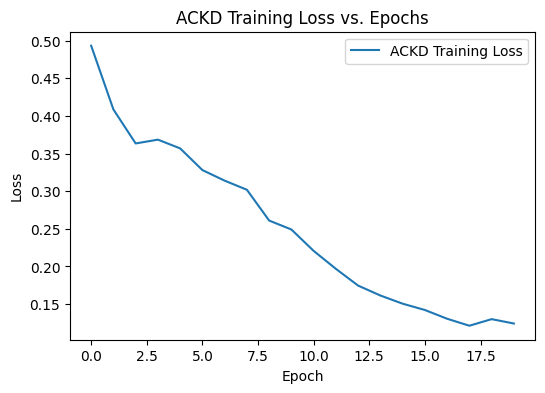

ID Accuracy:  90.06%
OOD Accuracy: 39.01%
Test Accuracy:64.53%
Color Sensitivity Score (CSS): 0.0145
Feature Independence Score (FIS): 0.2372
Mutual Information B_MI: 0.2092


In [22]:
# Cell 8

print("Starting ACKD Training on Student (ResNet18)...")
ackd_train_losses = ackd_training_loop(
    student=student_model,
    teacher=teacher_model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=EPOCHS,
    alpha=KD_ALPHA,
    T=KD_TEMPERATURE,
    lr=LR
)

plt.figure(figsize=(6,4))
plt.plot(ackd_train_losses, label='ACKD Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("ACKD Training Loss vs. Epochs")
plt.legend()
plt.show()

#######################
# Evaluate on ID and OOD
#######################
id_acc = evaluate_accuracy(student_model, id_loader, desc="ID Evaluation")
ood_acc = evaluate_accuracy(student_model, ood_loader, desc="OOD Evaluation")
test_acc = evaluate_accuracy(student_model, test_loader, desc="Test Evaluation")

print(f"ID Accuracy:  {id_acc:.2f}%")
print(f"OOD Accuracy: {ood_acc:.2f}%")
print(f"Test Accuracy:{test_acc:.2f}%")

#######################
# Evaluate Color Metrics
#######################
css_val = color_sensitivity_score(student_model, val_loader, delta_c=0.05, max_batches=10)
fis_val = feature_independence_score(student_model, val_loader, max_batches=10)
bmi_val = estimate_mutual_information(student_model, val_loader, num_bins=8)

print(f"Color Sensitivity Score (CSS): {css_val:.4f}")
print(f"Feature Independence Score (FIS): {fis_val:.4f}")
print(f"Mutual Information B_MI: {bmi_val:.4f}")

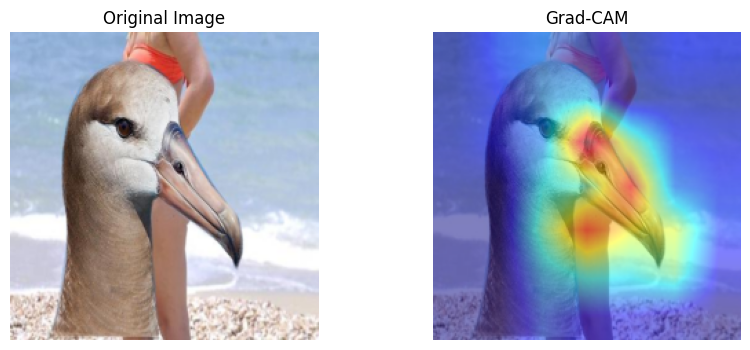

In [28]:
# Grad-CAM demonstration for student
from torchvision.utils import save_image
import cv2
import numpy as np
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt

def visualize_gradcam(model, data_loader, layer_name='layer4'):
    """
    Grab a single batch from data_loader, apply Grad-CAM, and show results on the first image.
    """
    model.eval()

    target_layer = getattr(model, layer_name)

    data_iter = iter(data_loader)
    images, labels, metadata = next(data_iter)
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    input_tensor = images[0].unsqueeze(0)
    input_img = input_tensor[0].permute(1, 2, 0).cpu().numpy()
    input_img = np.clip(input_img, 0, 1)

    cam = GradCAM(model=model, target_layers=[target_layer])
    grayscale_cam = cam(input_tensor=input_tensor)[0]  # shape [H, W]

    visualization = show_cam_on_image(input_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(input_img)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM")
    plt.axis("off")
    plt.show()

# Run Grad-CAM on one batch from test_loader (or id_loader/ood_loader)
visualize_gradcam(student_model, test_loader, layer_name='layer4')
